<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/SOA_talk_lognormal_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, make sure there is a GPU. On Google Colab, there are two type of GPU. One is Tesla K80 and the other is Tesla T4. T4 is more than twice as fast for our training

In [41]:
!nvidia-smi

Tue Aug 27 22:29:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    54W / 149W |   1139MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Update to the latest pytorch package. Pytorch 1.2 incorporated AdamW optimizer, which is an improvement over the regular Adam. 

In [42]:
!pip3 install torch torchvision --upgrade


Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.2.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [43]:

import torch
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.2.0
cuda


Parameters: one year (252 day) option. Daily hedging. 16% annualized volatility. The risk free rate is 2%. But the drift of the scenario is set to 0%. **The training can recover risk neural delta with real world scenario.**

In [0]:
d=252      #days of simulation
rf=0.02    #risk free rate
sigma=.16  #volatility
drift=0.0  #drift of the scenario

Generate scenarios for the training.  64 batch. 1024 scenario per batch

In [0]:
K1, K2 = 6, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

dt=torch.tensor(1/d,device=device)
sq_dt=torch.sqrt(dt)

s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
    idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)


t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                      
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]
#the chg is discounted to time zero already


In [0]:
t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

Here is the delta model.  It has two input, time to maturity and index level. There is only one output: delta. There are two middle layer of 32 node each. The count of trainable parameter is around one thousand. A much smaller network with around 200 parameters can produce pretty good but slightly accurate delta curve

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(2, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

In [48]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.02,
                              weight_decay=1e-5,amsgrad=True)
t1=time.time()
for t in range(200):
    for i in range(N1):
        optimizer.zero_grad()
        delta=model_delta(ts[i])
        delta=delta.view(N2,d)
        asset_gl=torch.sum(delta*chg[i],dim=1)
        hedged_price=asset_gl-pv_payout[i]
        loss=hedged_price.var()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
t2=time.time()
print(t2-t1)

0 0.00010712207586038858
10 1.567966683069244e-05
20 1.3331619811651763e-05
30 1.2811794476874638e-05
40 1.2275519111426547e-05
50 1.187951238534879e-05
60 1.202188286697492e-05
70 1.1877350516442675e-05
80 1.1623673344729468e-05
90 1.1614175491558854e-05
100 1.1735412954294588e-05
110 1.1915562936337665e-05
120 1.2043651622661855e-05
130 1.2080757187504787e-05
140 1.1822490705526434e-05
150 1.1487311894597951e-05
160 1.1369260391802527e-05
170 1.1317228199914098e-05
180 1.1946959602937568e-05
190 1.2169673027528916e-05
132.0451626777649


In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

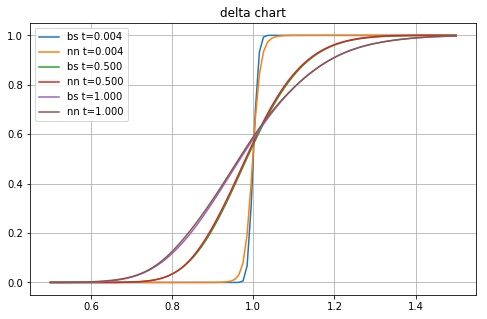

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[.004,.5,1.0]
for t in tl:
  s=torch.linspace(0.5,1.5,100,device=device)
  ts=torch.zeros((100,2),device=device)
  ts[:,0]=t
  ts[:,1]=s
  d_bs=delta_bs(s.cpu().numpy(),1,rf,0,t,sigma)
  d_nn=model_delta(ts)
  plt.plot(s.cpu().numpy(),d_bs,label="bs t="+ "%.3f" % t)
  plt.plot(s.cpu().numpy(),d_nn.cpu().view(100).detach().numpy(),
           label="nn t="+ "%.3f" % t)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()